<a href="https://colab.research.google.com/github/msc-acse/acse-8-miniproject-sigmoid/blob/master/KMNIST_ensemble_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook presents the implementations of probabilistic ensemble voting and transfer learning

# Setting Up Working Environment

## Sync to GitHub

In [1]:
from getpass import getpass
import os

user = getpass('github user')
password = getpass('github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

!rm -rf sigmoid
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-8-miniproject-sigmoid.git sigmoid

github user··········
github password··········
Cloning into 'sigmoid'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 213 (delta 34), reused 14 (delta 5), pack-reused 135
Receiving objects: 100% (213/213), 25.84 MiB | 23.77 MiB/s, done.
Resolving deltas: 100% (80/80), done.


## Sync to Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Install Dependencies and CUDA

In [3]:
%pylab inline
!pip install pycm albumentations
!pip install pycm livelossplot

from livelossplot import PlotLosses
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import time
import random
import copy

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Populating the interactive namespace from numpy and matplotlib
     |████████████████████████████████| 51kB 3.6MB/s 
     |████████████████████████████████| 491kB 14.5MB/s 
     |████████████████████████████████| 634kB 50.1MB/s 
     |████████████████████████████████| 215kB 59.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 4.5.3 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
Cud

## Import Tools to Perform Supervised Learning on KMNIST

In [0]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
from sigmoid.KMNISTLearning import *

# Define Model Classes

In [0]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    # The implementation of the LeNet5 architecture
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*5*5, 120)
    self.f6 = nn.Linear(120, 84)
    self.output = nn.Linear(84, 10)
    self.act = nn.ReLU()
    
  def forward(self, x):
    # Applying the ReLU activation function throughout the net
    x = self.act(self.c1(x))
    x = self.act(self.s2(x))
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
    x = self.act(self.c5(x))
    x = self.act(self.f6(x))
    return self.output(x)

In [0]:
class mLeNet5(nn.Module):
  def __init__(self):
    super(mLeNet5, self).__init__()
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*5*5, 1150)
    self.f6 = nn.Linear(1150, 256)
    self.output = nn.Linear(256, 10)
    self.act = nn.ReLU()
    self.dp = nn.Dropout(0.5)

  def forward(self, x):
    x = self.act(self.c1(x))
    x = self.act(self.s2(x))
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
    x = self.act(self.c5(x))
    x = self.dp(x)
    x = self.act(self.f6(x))
    x = self.dp(x)
    return self.output(x)

In [0]:
class AlexNetMod(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNetMod, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=4, padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [0]:
class DeepAlexNetMod(nn.Module):

    def __init__(self, num_classes=1000,train=True):
        super(DeepAlexNetMod, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=4, padding=0, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), 
            
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
        ) 
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        #print(x.shape)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [0]:
class SDeepAlexNetMod(nn.Module):

    def __init__(self, num_classes=1000):
        super(SDeepAlexNetMod, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=4, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(256, 384, kernel_size=5, padding=2),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )   
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        

    def forward(self, x):
        x = self.features(x)
        #print(x.shape)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

# Import Data as `torch.Tensor`

In [45]:
# Import Data
path="/content/gdrive/My Drive/Sigmoid/"
train_data = np.load(path+"kmnist-train-imgs.npy")
test_data = np.load(path+"kmnist-test-imgs.npy")
train_labels = np.load(path+"kmnist-train-labels.npy")
classmap = pd.read_csv(path+"kmnist_classmap.csv")

# Tensor of training data
X = torch.from_numpy(train_data).float()
# Tensor of training labels
y = torch.from_numpy(train_labels).long()
#  Tensor of test data
X_test = torch.from_numpy(test_data).float()

# Size Check
print("Train Data:", X.size())
print("Test Data:", X_test.size())
print("Train Labels:", y.size())

Train Data: torch.Size([60000, 28, 28])
Test Data: torch.Size([10000, 28, 28])
Train Labels: torch.Size([60000])


#**Ensemble Learning**

In [0]:
# Hyperparameters
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 2
patience=5
early_stop_tol = 0.000
n_folds=3
weight_decay=0
loss_function = nn.CrossEntropyLoss()

## Creating model object to split data into training/validation sets

In [0]:
path = "/content/gdrive/My Drive/Sigmoid/Models/"

# Model Name
MODEL_NAME = "lenet5_980"

# Define/Load Model, Optimiser and Loss Function
model_Lenet5 = model_load("/content/gdrive/My Drive/Sigmoid/Models/", MODEL_NAME)

optimiser = torch.optim.SGD(model_Lenet5.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
learning = SupervisedLearning(X, y, model_Lenet5, optimiser, loss_function, batch_size, test_batch_size,
                device=device,
                transform=False,
                seed=42, n_epochs=n_epochs,
                val_ratio=0.1, n_splits=n_folds+1)
norm_mean, norm_std = torch.mean(X/255.), torch.std(X/255.)
learning.split_data()

## Combining models

In [73]:
model_dir = os.listdir(path)
ensemble_list = []
test_acc_list = []
# If the validation score is above 98% then it is included in our ensemble 
print("Models Included:")

for name in model_dir:
  if name[-3:] == "pth":
    model = model.to(device)
    ensemble_list.append(model)
    print(name)
    # Used to originally determine which models should be included
    # but only useful on those models that had not been trained on the 
    # full training set (including validation set)
    #y_preds, sub = evaluate(learning.X_val, model, norm_mean, norm_std, test_batch_size=30, test_transform=None, device=device, ensemble=False)
    #test_acc = accuracy_check(y_preds, learning.y_val)
    #if test_acc > 0.95:
    #  print(name, test_acc)
    #  test_acc_list.append(test_acc)
    #  ensemble_list.append(model)

ensemble = ensemble_net(ensemble_list)
y_preds_ens, sub = evaluate(X_test/255., ensemble, norm_mean, norm_std, test_batch_size=30, test_transform=None, device=device, ensemble=True, save_to_csv=True, path=path+"ensemble.csv")
print("\nThis ensemble achieved a test score of 0.97833")

Models Included:
lenet5_920.pth
lenet5_958.pth
lenet_rot10_jitt_979.pth
lenet_drop_aug_986.pth
lenet5_980.pth
mlenet5_test_916.pth
mlenet5_test_919.pth
lenet5_test_927.pth
lenet5_test_924.pth
lenet5_test_931.pth
mlenet5_test_921.pth
alex_aug_full_9703.pth
alex_aug_992.pth
deepalex_old_aug_subset_9940.pth
deepalex_old_aug_full_9806.pth
alexnetmod_full_new_aug_963.pth
alexnetmod_full_new_aug_983.pth
SDeep_model_full_old_aug_.pth
SDeep_model_full_old_aug_0.pth
mlenet5_test_914.pth
SDeep_model_full_old_aug_continue_0.pth
dAlexTransferNewAug_0.pth
alex_old_aug_subset_adam_994.pth
SDeepAlex_model_NewAug_full_.pth
Deepalex_new_aug_full_adam_0.pth
dAlexTransfer_0.pth
dAlexTransferNewAugSingleLayer_0.pth

This ensemble achieved a test score of 0.97833


## Transfer Learning with Alexnet

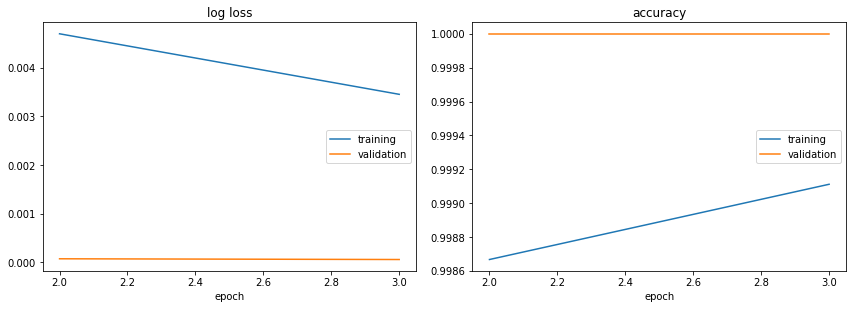

log loss:
training   (min:    0.003, max:    0.005, cur:    0.003)
validation (min:    0.000, max:    0.000, cur:    0.000)

accuracy:
training   (min:    0.999, max:    0.999, cur:    0.999)
validation (min:    1.000, max:    1.000, cur:    1.000)
Count: 0
Saving model under: /content/gdrive/My Drive/Sigmoid/Models/dAlexTransfer_0.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DeepAlexNetMod. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Test Set Predictions: [2 9 3 ... 9 4 2]


In [26]:
# Model Name
MODEL_NAME = "deepalex_old_aug_full_9806"
# Number of layers that will have non-zero learning lates
LAYERS = 1

# Hyperparameters
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 3
patience=10
early_stop_tol = 0.000
n_folds=0
weight_decay=1e-4
loss_function = nn.CrossEntropyLoss()

# Define/Load Model, Optimiser and Loss Function
alexnet = model_load("/content/gdrive/My Drive/Sigmoid/Models/", MODEL_NAME)

# Setting the learning rate throughout the network to 0 
# unless they are in the final n LAYERS
lr_dic = []
for i in range(0, len(alexnet.classifier)-LAYERS):
  lr_dic.append({'params': alexnet.classifier[i].parameters(), 'lr': 0.0})
for i in range(0, len(alexnet.features)):
  lr_dic.append({'params': alexnet.features[i].parameters(), 'lr': 0.0})
  
lr_dic.append({'params': alexnet.classifier[-1].parameters(), 'lr': lr})
optimiser = torch.optim.SGD(lr_dic, momentum=momentum, weight_decay=0)

# Create Supervised Learning Object
learning = SupervisedLearning(X, y, alexnet, optimiser, loss_function, batch_size, test_batch_size,
                 device=device,
                 transform=True, 
                 seed=42, n_epochs=n_epochs,
                 val_ratio=0.1, n_splits=n_folds+1, 
                 early_stop = True,
                 patience = patience,
                 tol = early_stop_tol)

learning.train_wrapper(train_full=False)

# Saving model
# Model Name
MODEL_NAME = "dAlexTransfer"
path = F"/content/gdrive/My Drive/Sigmoid/Models/"

full_save(path, MODEL_NAME, model, optimiser, loss_function, early_stop_tol, learning.logs["_i"], lr, momentum, weight_decay, n_folds, learning.transform, learning.logs["val_accuracy"], learning.logs["val_log loss"], train_time=learning.logs["time"])

# Evaluate and save test dataset prediction
norm_mean, norm_std = torch.mean(X/255.), torch.std(X/255.)
y_preds, sub = evaluate(X_test, model, norm_mean, norm_std, 
                                       test_batch_size=test_batch_size, 
                                       test_transform=None, 
                                       device=device, 
                                       save_to_csv=False, 
                                       path=path+MODEL_NAME+".csv")

print("\nTest Set Predictions:", y_preds)

## Transfer Learning - AlexNet with Augmented Data

In [0]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, Cutout, 
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


def augment_data(X, y, transforms, n_add=1000):
  """ 
  Function to produce n_add augmented images from an image dataset
  Params
  -----
  X: torch.tensor of size (n_images, 28, 28) images dataset
  y: torch.tensor of size (n_images) images targets int
  transforms: albumentations.Compose object
  n_add: in number of images to add
  
  Returns
  -------
  X_aug, y_aug: np.arrays of images and targets with augmented adition
  """
  # reserve space to store augmented images
  X_aug = np.zeros((X.shape[0]+n_add, X.shape[1], X.shape[2]),dtype=uint8)
  X_aug[:X.shape[0]]=X.numpy().copy()
  
  y_aug = np.zeros(X.shape[0]+n_add)
  y_aug[:X.shape[0]] = y.numpy().copy()
  
  # keep track of how many augmented images have been added
  aug_count = 0
  
  while aug_count < n_add:
    for i in range(X.shape[0]):
      image_1c = X[i].numpy().astype(np.uint8)

      # transform to 3 channels
      image= np.zeros((28,28,3), dtype=uint8)
      image[:,:,0] = image_1c
      image[:,:,1] = image_1c
      image[:,:,2] = image_1c

      # transform and save single channel
      data = {"image": image}
      img_aug = transforms(**data)   
      img_aug = img_aug["image"][:,:,0]
      
      aug_count = aug_count + 1
      #print("number of augmented images: ", aug_count)
      if aug_count >= n_add:
        break

      X_aug[X.shape[0]+aug_count] = img_aug 
      y_aug[X.shape[0]+aug_count] = int(y[i].item())
  
  return X_aug, y_aug


def strong_aug(p=0.5):
    return Compose([
        
        Cutout(num_holes=4, max_h_size=4, max_w_size=4, p=0.4),
        
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
            
        ], p=0.8),
        
        OneOf([
            MotionBlur(blur_limit=3,p=0.1),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.01),
        
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.7),
        
        OneOf([
            OpticalDistortion(p=0.1),
            GridDistortion(p=0.2),
            IAAPiecewiseAffine(p=0.2),
        ], p=0.5),
        
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            RandomBrightnessContrast(),
        ], p=0.3),
        
        HueSaturationValue(p=0.3),
    ], p=p)

In [0]:
# Creaing the augmented dataset
# Only a small amount of additional images are included here
# for demonstation purposes
X_aug, y_aug = augment_data(X, y, strong_aug(1), n_add=1000)
X_aug, y_aug = torch.from_numpy(X_aug), torch.from_numpy(y_aug).long()

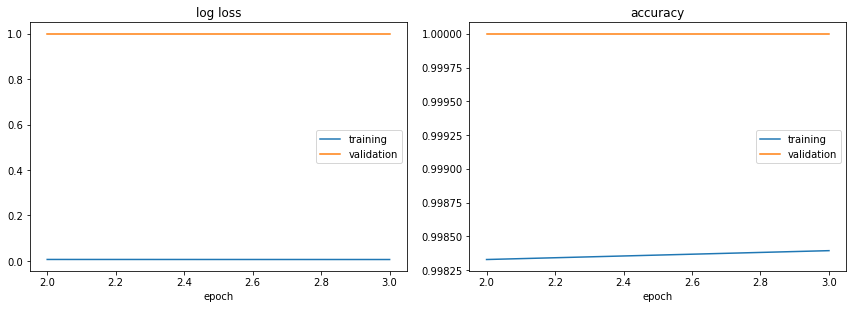

log loss:
training   (min:    0.006, max:    0.006, cur:    0.006)
validation (min:    1.000, max:    1.000, cur:    1.000)

accuracy:
training   (min:    0.998, max:    0.998, cur:    0.998)
validation (min:    1.000, max:    1.000, cur:    1.000)
Count: 0


In [30]:
# Model Loading Name
MODEL_NAME = "deepalex_old_aug_full_9806"
# Number of layers that will have non-zero learning lates
LAYERS = 1

# Hyperparameters
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 3
patience=10
early_stop_tol = 0.000
n_folds=0
weight_decay=1e-4
loss_function = nn.CrossEntropyLoss()

# Define/Load Model, Optimiser and Loss Function
alexnet = model_load("/content/gdrive/My Drive/Sigmoid/Models/", MODEL_NAME)

# Setting the learning rate throughout the network to 0
# unless they are in the final n LAYERS
lr_dic = []
for i in range(0, len(alexnet.classifier)-LAYERS):
  lr_dic.append({'params': alexnet.classifier[i].parameters(), 'lr': 0.0})
for i in range(0, len(alexnet.features)):
  lr_dic.append({'params': alexnet.features[i].parameters(), 'lr': 0.0})

lr_dic.append({'params': alexnet.classifier[-1].parameters(), 'lr': lr})
optimiser = torch.optim.SGD(lr_dic, momentum=momentum, weight_decay=weight_decay)

# Create Supervised Learning Object
# X_aug, y_aug = torch.from_numpy(X_aug), torch.from_numpy(y_aug).long()
learning = SupervisedLearning(X_aug, y_aug.long(), alexnet, optimiser, loss_function, batch_size, test_batch_size,
                device=device,
                transform=False,
                seed=42, n_epochs=n_epochs,
                val_ratio=0.1, n_splits=n_folds+1,
                early_stop = True,
                patience = patience,
                tol = early_stop_tol)

learning.train_wrapper(train_full=True)

In [32]:
# Saving model
# Model Name
MODEL_NAME = "dAlexTransferNewAugSingleLayer"
path = F"/content/gdrive/My Drive/Sigmoid/Models/"

full_save(path, MODEL_NAME, model, optimiser, loss_function, early_stop_tol, learning.logs['_i'], lr, momentum, weight_decay, n_folds, True, learning.logs['val_accuracy'], learning.logs['val_log loss'], train_time=learning.logs['time'])

# Evaluate and save test dataset prediction
norm_mean, norm_std = torch.mean(X/255.), torch.std(X/255.)
y_preds, sub = evaluate(X_test, model, norm_mean, norm_std,
                                      test_batch_size=test_batch_size,
                                      test_transform=None,
                                      device=device,
                                      save_to_csv=False,
                                      path=path+MODEL_NAME+'.csv')

print("\nTest Set Predictions:", y_preds)

Saving model under: /content/gdrive/My Drive/Sigmoid/Models/dAlexTransferNewAugSingleLayer_0.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DeepAlexNetMod. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Test Set Predictions: [2 9 3 ... 9 4 2]
